## Тут просто ручная реализация логистической регрессии с сигмоидой и регуляризацией на датасете Titanic

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [9]:
def prepare_dataset(df):
    df = df.drop(['Name', 'Ticket', 'Cabin', 'Embarked'], axis=1)
    df['Sex'] = (train_data['Sex'] == 'male').astype(np.int) * 2 - 1
    df = df.fillna({'Age': df['Age'].mean()})
    df['Age'] /= 100
    df['Fare'] /= 100
    df['_bias'] = 1
    if 'Survived' in df.columns:
        return df.drop(['Survived'], axis=1), (df['Survived'] * 2 - 1)
    else:
        return df

In [10]:
train_data = pd.read_csv('../data/titanic/train.csv')
train_features, train_answers = prepare_dataset(train_data)

In [11]:
features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', '_bias']
X = train_features[features].to_numpy()
y = train_answers.to_numpy()

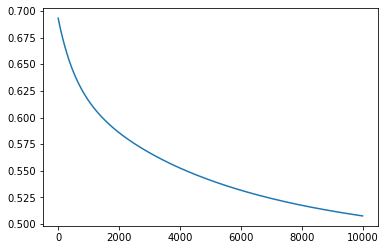

In [12]:
from tqdm.notebook import tqdm
iterations = 10000
alpha = 5e-4
tau = 1e-4

def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

w = np.zeros((X.shape[1]))
errors = []
best_w = w
best_err = None
for it in tqdm(range(iterations)):
    errors.append(tau / 2 * np.sum(w**2) +
                  -np.mean(np.log( sigmoid(y * (X @ w)) ) )
                 )
    if best_err is None or errors[-1] < best_err:
        best_w = w
        best_err = errors[-1]
    w -= alpha * (-np.array([
        np.dot(y * sigmoid(- y * (X @ w)), X[:, j])
        for j in range(X.shape[1])
    ]) / X.shape[0] + tau * w)
    if it % 2000 == 0: alpha *= 0.99

plt.plot([i for i in range(len(errors))], errors)

In [6]:
print(best_err, dict(zip(features, best_w)))

0.5083628590243644 {'Pclass': -0.25448221014982475, 'Sex': -0.7259809907909153, 'Age': -0.002754196717751497, 'SibSp': -0.06649224548174588, 'Parch': 0.07284822343355604, 'Fare': 0.2028887945428732, '_bias': 0.07663128918250531}


In [7]:
train_predictions = (sigmoid(X @ w) >= 0.5).astype(np.int) * 2 - 1
print('Score: {}'.format( np.mean( train_predictions == y ) ))

Score: 0.8024691358024691


## Инфраструктура для консенсуса

Как происходит коммуникация: каждый агент получает на каждого соседа пару (read, write) asyncio очередей для общения.
Аналогично с мастер-нодой консенсуса.

Протокол консенсуса в данный момент такой:
1. Мастер-нода получает топологию и агентов;
2. Мастер-нода устанавливает связь между собой и агентами (передает сокеты);
3. Мастер-нода передает сокеты для общения между агентами;
4. Мастер передает всем агентам NETWORK_READY;
4. Агенты заявляют о готовности начать новый раунд консенсуса (отправляют NEW_ROUND мастеру);
5. Когда все агенты готовы, мастер посылает всем NEW_ROUND --- начинается новый раунд консенсуса;
6. Агенты вычисляют функцию;
7. Агенты запрашивают у соседей значение их функции (отправка REQUEST_VALUE) и получают от соседей посчитанное значение;
8. Когда агент понимает, что он сошелся с соседями, он посылает мастеру CONVERGED (но при этом агент все еще должен участвовать в коммуникации с соседями);
9. Если агент понял, что сходимость не достигнута, то он может отменить CONVERGED отправкой NOT_CONVERGED;
10. Когда все агенты заявили о том, что значение сошлось, мастер посылает всем DONE;
11. jmp 5

In [5]:
topology_pair = [(0, 1)]
topology_cycle_3 = [(0, 1), (1, 2), (2, 0)] 
topology_grid_5 = [('center', 'west'), ('center', 'east'), ('center', 'north'), ('center', 'south'),
                   ('west', 'north'), ('north', 'east'), ('east', 'south'), ('west', 'south')]
'''
     @
    /|\
   @-@-@  topology_grid_5
    \|/
     @
'''
from consensus import *

Посчитаем среднее пяти случайных чисел

In [6]:
consensus_shutdown = asyncio.Queue()
consensus_network = ConsensusNetwork(topology_grid_5, consensus_shutdown, debug=True)
agents = [ConsensusAgent(token, debug=True) for token in consensus_network.tokens]
for a in agents:
    consensus_network.register_agent(a)

tasks = [asyncio.create_task(consensus_network.serve())] + [asyncio.create_task(a.run_round(np.random.random(), 1)) for a in agents]
async def shutdown_after_timeout(timeout):
    await asyncio.sleep(timeout)
    await consensus_shutdown.put(SHUTDOWN)
asyncio.create_task(shutdown_after_timeout(1))
for coro in asyncio.as_completed(tasks):
    t = await coro
    print(t)

Got 1/5 agents
Got 2/5 agents
Got 3/5 agents
Got 4/5 agents
Got 5/5 agents
Agent "east" heard from master
Agent "south" heard from master
Agent "center" heard from master
Agent "north" heard from master
Agent "west" heard from master
Agent "east" got neighbors from master
Agent "south" got neighbors from master
Agent "center" got neighbors from master
Agent "north" got neighbors from master
Agent "west" got neighbors from master
Master: serving...
Agent "east": running new round with v=0.48122224949558023, w=1
Agent "east" initialized. Waiting for NETWORK_READY
Agent "east" got NETWORK_READY
Agent "east" clearing queues
Agent "east" sending NEW_ROUND to master
Agent "south": running new round with v=0.1643392453845426, w=1
Agent "south" initialized. Waiting for NETWORK_READY
Agent "south" got NETWORK_READY
Agent "south" clearing queues
Agent "south" sending NEW_ROUND to master
Agent "center": running new round with v=0.5142043714312501, w=1
Agent "center" initialized. Waiting for NETWO

0.48083506573395507
0.4808350645534739
0.4808350656936658
0.48083506742879395
0.48083506505844004
None


Master: ===== SHUTDOWN =====


## Применение для титаника

Хотим ~~распределенно~~ считать градиент и усреднять его между агентами.

In [10]:
def sigmoid(x):
        return 1.0 / (1.0 + np.exp(-x))

progress_info = {}
    
async def learning_instance(X, y, agent, iterations=50000):
    alpha = 5e-4
    tau = 1e-4

    w = np.zeros((X.shape[1]))
    errors = []
    best_w = w
    best_err = None
    for it in range(iterations):
        errors.append(tau / 2 * np.sum(w**2) +
                      -np.mean(np.log( sigmoid(y * (X @ w)) ) )
                     )
        if best_err is None or errors[-1] < best_err:
            best_w = w
            best_err = errors[-1]
        grad = -np.array([
            np.dot(y * sigmoid(- y * (X @ w)), X[:, j])
            for j in range(X.shape[1])
        ]) / X.shape[0] + tau * w
        # print(agent.token, grad, X.shape[0])
        consensus_grad = await agent.run_round(grad, X.shape[0])        
        # print('Agent "{}": CONSENSUS: {}'.format(agent.token, consensus_grad), file=sys.stderr)
        w -= alpha * consensus_grad
        if it % 2000 == 0: alpha *= 0.99
        progress_info[agent.token] = (it + 1) / iterations

    return best_w, best_err, errors
    # plt.plot([i for i in range(len(errors))], errors)

def split_data(X, y, topology):
    tmpX = X.copy()
    tmpy = y.copy()
    tokens = list(set(np.array(topology).flatten()))
    num = len(tokens)
    result = dict()
    for i in range(num):
        left_tokens = num - i
        left_data = len(tmpX)
        ln = left_data // left_tokens
        result[tokens[i]] = (tmpX[:ln], tmpy[:ln])
        tmpX, tmpy = tmpX[ln:], tmpy[ln:]
    return result

In [11]:
consensus_network = ConsensusNetwork(topology_grid_5, None)
consensus_network.describe()

Laplacian:
[[ 3 -1 -1 -1  0]
 [-1  4 -1 -1 -1]
 [-1 -1  3  0 -1]
 [-1 -1  0  3 -1]
 [ 0 -1 -1 -1  3]]
Eigenvalues: [0. 3. 3. 5. 5.]
Algebraic connectivity: 3.0000000000000004
Perron matrix:
[[0.2575 0.2475 0.2475 0.2475 0.    ]
 [0.2475 0.01   0.2475 0.2475 0.2475]
 [0.2475 0.2475 0.2575 0.     0.2475]
 [0.2475 0.2475 0.     0.2575 0.2475]
 [0.     0.2475 0.2475 0.2475 0.2575]]
Eigenvalues: [-0.2375 -0.2375  0.2575  0.2575  1.    ]
Convergence speed: 0.056406249999999984


Вычисление 10000 итераций может занять минут 10, т.к. пока всё в один поток.

FloatProgress(value=0.0, max=1.0)

Task was destroyed but it is pending!
task: <Task pending name='Task-654' coro=<ConsensusNetwork.serve() running at <ipython-input-8-82148c7a95f1>:106> wait_for=<Future pending cb=[<TaskWakeupMethWrapper object at 0x7f4d1f0cabb0>()]>>
Task was destroyed but it is pending!
task: <Task pending name='master check shutdown' coro=<Queue.get() running at /home/remmargorp/anaconda3/lib/python3.8/asyncio/queues.py:163> wait_for=<Future pending cb=[<TaskWakeupMethWrapper object at 0x7f4d1f06ea30>()]>>
Task was destroyed but it is pending!
task: <Task pending name='master check agent "center"' coro=<Queue.get() running at /home/remmargorp/anaconda3/lib/python3.8/asyncio/queues.py:163> wait_for=<Future pending cb=[<TaskWakeupMethWrapper object at 0x7f4d1f0c8f10>()]>>
Task was destroyed but it is pending!
task: <Task pending name='master check agent "south"' coro=<Queue.get() running at /home/remmargorp/anaconda3/lib/python3.8/asyncio/queues.py:163> wait_for=<Future pending cb=[<TaskWakeupMethWrap

Score: 0.792368125701459
Score: 0.792368125701459
Score: 0.792368125701459
Score: 0.792368125701459
Score: 0.792368125701459
[-2.54593478e-01 -7.22743176e-01 -3.93502280e-04 -5.50700802e-02
  7.39084010e-02  2.18059849e-01  8.31621898e-02]
[-2.54593478e-01 -7.22743177e-01 -3.93502708e-04 -5.50700817e-02
  7.39084010e-02  2.18059848e-01  8.31621888e-02]
[-2.54593482e-01 -7.22743179e-01 -3.93503205e-04 -5.50700846e-02
  7.39084015e-02  2.18059847e-01  8.31621867e-02]
[-2.54593485e-01 -7.22743177e-01 -3.93502537e-04 -5.50700830e-02
  7.39084001e-02  2.18059847e-01  8.31621872e-02]
[-2.54593485e-01 -7.22743176e-01 -3.93502446e-04 -5.50700828e-02
  7.39083989e-02  2.18059848e-01  8.31621874e-02]


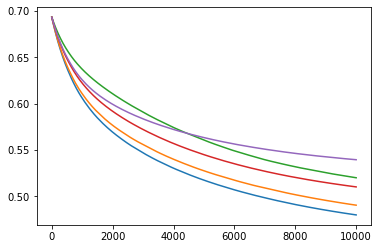

In [12]:
async def run(topology, iterations=100, debug=False):
    dl_data = split_data(X, y, topology)
    consensus_shutdown = asyncio.Queue()
    consensus_network = ConsensusNetwork(topology, consensus_shutdown, debug=debug)
    agents = [ConsensusAgent(token, eps=1e-6, debug=debug) for token in consensus_network.tokens]
    for a in agents:
        consensus_network.register_agent(a)

    async def print_progress():
        from ipywidgets import IntProgress, FloatProgress, FloatText
        from IPython.display import display

        progress = FloatProgress(min=0.0, max=1.0, step=0.01, value=0.0)
        display(progress)
        while True:
            v = list(progress_info.values())
            if len(v) > 0:
                p = np.mean(v)
                progress.value = p
            await asyncio.sleep(0.25)

    progress_task = asyncio.create_task(print_progress())
    tasks = [asyncio.create_task(
                learning_instance(dl_data[a.token][0], dl_data[a.token][1], a, iterations=iterations)
             ) for a in agents]
    best_ws = []
    asyncio.create_task(consensus_network.serve())

    for coro in asyncio.as_completed(tasks):
        best_w, best_err, errors = await coro
        best_ws.append(best_w)
        plt.plot([i for i in range(len(errors))], errors)
    progress_task.cancel()

    for w in best_ws:
        train_predictions = (sigmoid(X @ w) >= 0.5).astype(np.int) * 2 - 1
        print('Score: {}'.format( np.mean( train_predictions == y ) ))

    for w in best_ws:
        print(w)

await run(topology_grid_5, 10000)